# Feladatkitűzés

Célul tűztük ki magunk elé, hogy -mivel a MSZO CNC projektjének résztvevői vagyunk- az épülő CNC géphez alkossunk valami hasznosat. Az órákon képfeldolgozással foglalkoztunk, így adódott az ötlet, hogy alakítsuk át a programnak beadott képet olyan kóddá, hogy a gép számára az használható legyen. Eredeti ötletünkben a szabványos GCODE szerepelt, de - mivel szeretjük a kihívásokat- új nyelv létrehozása mellett döntöttünk, ami még jobban illeszkedik a saját projektünkhöz. A nyelv rendkívül egyszerű. Parancsai:
* x;y   x>=0 és y>=0   A marófej az x;y pontba mozog
* -1;0                 A marófej leereszkedik
* 0;-1                 A marófej felemelkedik
* -1;-1                A marófej megáll és fejcserére vár. (ez a jelenlegi verzióban még nem fog működni.)

A bemenetként kapott képet txt fájlba alakítja át, ami minden sorában egy ilyen parancsot tartalmaz.

## Átalakító

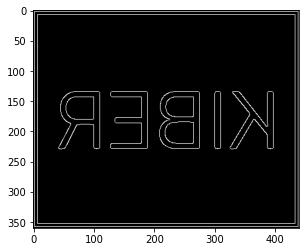

In [16]:
#könyvtárak importálása
import cv2
import numpy as np
from skimage import feature
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
from time import localtime, strftime


#kép beolvasása és szürekeárnyalatossá alakítása
be="kiber.png"
im = cv2.imread(be)
im = np.array(im, dtype=np.uint8)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

#kimenet:szövegfájl
ki=be.split(".")
ki=ki[0]+".txt"
file = open(ki, "w")
#file.write(strftime("%d-%b-%Y-%H.%M.%S---", localtime()))
#file.write(ki)
#file.write(":")
file.write(str(im.shape[0])+";"+str(im.shape[1]))
file.write("\n")


#élkeresés
edges = feature.canny(im)
#élek megjelenítése
plt.imshow(edges,'gray')
plt.show()

#nemzérus pixel kereső függvény
def keres(kep):
    k=0
    kp=np.zeros((2,1))
    for i in range(0,kep.shape[0]):
        for j in range(0,kep.shape[1]):
            if kep[i,j]==1 and k==0:
                kp[0]=int(i)
                kp[1]=int(j)
                k=1
                
    return kp


##alap paraméterek megadása: kezdőpont inicializálása
kezdopont=keres(edges)
kovpont=[int(kezdopont[0]),int(kezdopont[1])]
file.write(str(kovpont))
file.write("\n")
file.write("[-1,0]")
file.write("\n")


#átalakítás. a while azért végtelen, mert úgyis kilép
while 1:
    p0=int(kovpont[0])
    p1=int(kovpont[1])
    #aktuális pixel törlése
    edges[p0,p1]=0
    
    
    #ha megszüntetjük a kommentelést, minden lépést kirajzol.
    '''io.imshow(edges)
    io.show()
    '''
    
    
    #kovpont inicializálása hibás adattal. a [-1,-1] a hibás adat, amit nem szeretünk. [0,-1]:toll fel, [-1,0]:toll le
    kovpont=-np.ones((2,1))
    
    #első típus: a következő pont az előző alatt/fölött/mellett van
    if edges[p0-1,p1]==True:
        kovpont=[p0-1,p1]
    elif edges[p0+1,p1]==True:
        kovpont=[p0+1,p1]
    elif edges[p0,p1-1]==True:
        kovpont=[p0,p1-1]
    elif edges[p0,p1+1]==True:
        kovpont=[p0,p1+1]
    elif edges[p0-1,p1-1]==True:
        kovpont=[p0-1,p1-1]
    elif edges[p0-1,p1+1]==True:
        kovpont=[p0-1,p1+1]
    elif edges[p0+1,p1-1]==True:
        kovpont=[p0+1,p1-1]
    elif edges[p0+1,p1+1]==True:
        kovpont=[p0+1,p1+1]
    
    #második típus: nem közvetlenül mellette van, de max 1 zérus pixel van köztük(pl hibás kép)
    elif p0>2 and p0<edges.shape[0]-2 and p1>2 and p1<edges.shape[1]-2 :
        for i in range(p0-2,p0+3):
            for j in range(p1-2,p1+3):
                if edges[i,j]==True:
                    kovpont=[i,j]
    
    #kiírás
    if kovpont[0]!=-1 or kovpont[1]!=-1:
        file.write(str(kovpont))
        file.write("\n")
        
    #harmadik típus: nincs a közelben nemzérus pixel, újat keres (ilyenkor kell tollfelemelés)
    else:
        k=int(keres(edges)[0])
        l=int(keres(edges)[1])
        #feltétel a befejezésre. ha nem talál újat, kilép. A [0,0] azért lehet kilépési feltétel, mert ez a legelső pont,
        #amit vizsgál a keresőfüggvény, tehát az első lépésnél már bejártuk, ha létezik 
        if k==0 and l==0:
            file.write("[0,-1]")
            file.write("\n")
            #nullázás
            file.write("[0,0]")
            file.write("\n")
            break
        #ha talál újat, itt folytatja
        else:
            kovpont=[k,l]
        
        file.write("[0,-1]")
        file.write("\n")
        file.write(str(kovpont))
        file.write("\n")
        file.write("[-1,0]")
        file.write("\n")

    
file.close()

## Olvasó


In [1]:
#könyvtárak importálása:
from graphics import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import paho.mqtt.client as mqtt

#gép adatai
x_g=440 #[-250;190]
x_0=-250
y_g=360 #[-260;100]
y_0=-260
z_g=110 #[0;-110]
z_0=0

xd_0=-430
zd_0=635

#rajzterület, pixel arány (1 esetén teljes rajzterület)
a=1

#mqtt szerverre való csatlakozás

# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected successfully")
    else:
        print("Connect returned result code: " + str(rc))

# The callback for when a PUBLISH message is received from the server.
def on_message(client, userdata, msg):
    print("Received message: " + msg.topic + " -> " + msg.payload.decode("utf-8"))

# create the client
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

# enable TLS
client.tls_set(tls_version=mqtt.ssl.PROTOCOL_TLS)

# set username and password
client.username_pw_set("mqtt", "maxwhere123")

# connect to HiveMQ Cloud on port 8883
client.connect("mqtt.maxwhere.com", 8883)

#szövegfájl megnyitása,és sorainak megszámlálása
be="kiber.txt"
n=0
file = open(be,"r") 
for line in file:
    n+=1
file.close()
print(n," lépés a rajzolás.")

#szövegfájl beolvasása tömmbe, és az adatok használhatóvá alakítása
kimenet=np.ones((n,2))
file = open(be,"r") 
n=-1
up=False
x_e=0
y_e=0
z_e=-200

for line in file:
    n+=1
    if n>0:
        sor = line.replace(']','').replace('[','').replace('\n','').replace(' ','').replace('"','').split(",")
        #print(sor)
        if sor[0]=='-1' and sor[1]=='0':
            for z in range(0,100):
                client.publish("CNC_digital_twin/mcoordinates",'{"x":'+ str(x_e) + ',"y":' + str(y_e) + ',"z":' + str(-z)+'}')
                z_e=-z
                up=False
                time.sleep(0.01)
                
        elif sor[0]=='0' and sor[1]=='-1':
            for z in range(0,100):
                client.publish("CNC_digital_twin/mcoordinates",'{"x":'+ str(x_e) + ',"y":' + str(y_e) + ',"z":' + str(-100+z)+'}')
                z_e=z-100
                up=True
                time.sleep(0.01)
                
        elif up==True:
            if (int(sor[1])*x_a+x_0)<x_e:
                x_i=-0.4
            else:
                x_i=+0.4
                
            if (int(sor[0])*y_a+y_0)<y_e:
                y_i=-0.4
            else:
                y_i=+0.4
                
            x_ready=False
            y_ready=False
            ready=False
                
            while ready==False:
                if round((int(sor[1])*x_a)+x_0)!=round(x_e):
                    x_e+=x_i
                   
                else:
                    x_ready=True
                    
                if round((int(sor[0])*y_a)+y_0)!=round(y_e):
                    y_e+=y_i
                    #client.publish("CNC_digital_twin/coordinates/y",'{"x":'+ str(0) + ',"y":' + str(y_e) + ',"z":' + str(0)+'}')
                    #print("y_e:" + str(round(y_e)) + " y_i: " + str(y_i) + " sor: " + str(round(int(sor[1])*y_a+y_0)) + " y_kész=" + str(y_ready) )
                else:
                    y_ready=True
                    
                
                client.publish("CNC_digital_twin/mcoordinates",'{"x":'+ str(round(x_e,3)) + ',"y":' + str(round(y_e,3)) + ',"z":' + str(round(z_e,3))+'}' )
                
                ready= x_ready and y_ready
                
                time.sleep(0.005)
                    
            
            
                
        else:
            client.publish("CNC_digital_twin/mcoordinates",'{"x":'+ str(round((int(sor[1])*x_a)+x_0,4)) + ',"y":' + str(round((int(sor[0])*y_a)+y_0,4)) + ',"z":' + str(z_e)+'}' )
            if n%5==0:
                client.publish("CNC_digital_twin/dcoordinates",'{"x":'+ str(round((int(sor[1])*x_a)+xd_0,4)) + ',"y":' + str(305) + ',"z":' + str(round((int(sor[0])*(-y_a))+zd_0,4))+'}' )
            x_e=int(round((int(sor[1])*x_a)+x_0,1))
            #print("x:"+str(round((int(sor[0])*x_a)+x_0,1)))
            y_e=int(round((int(sor[0])*y_a)+y_0,1))
            #print("y:"+str(round((int(sor[1])*y_a)+x_0,1)))
        time.sleep(0.005)
        
    else:
        inic=line.replace('\n','').split(";")
        if(int(inic[0])>int(inic[1])):
            x_a=x_g/int(inic[1])/a
            y_a=x_a
        else:
            y_a=y_g/int(inic[0])/a
            x_a=y_a
        #print("x irányú nagyítás: "+str(x_a)+" y irányú nagyítás: "+str(y_a))
file.close()

5608  lépés a rajzolás.
